# Домашнее задание 5: инструменты A/B-тестирования

## Теоретическая часть

**Гипотеза**: Если мы снизим стоимость поездки на 5% для пользователей Android в выходные дни, то количество отмен сократится на 2%, потому что цена станет более привлекательной для клиента.

**Тестируемое изменение**: Как снижение стоимости поездки повлияет на количество отменённых заказов

**Бизнес-цель**: Сокращение количества отмен заказов

**Генеральная совокупность**: Пользователи Android

**Первичная метрика**: Количество отмен заказов

**Вторичная метрика**: Средняя выручка

**Метод агрегации метрик**: общее значение метрики


**Текущее состояние и план**:

Текущее количество отмен = 15%   (см. ячейка 13)

Желаемое уменьшение = 2 п.п.

Минимальный объём выборки = 600 (см. ячейка 21)

Уровень значимости: 5%

Мощность теста: 80%

MDE: 0.039583 (см. ячейка 22)

**Разделение на группы**: (см. ячейки 24-26)
* выделили группу пользователей андроид, со средним показателем отмены заказов
* рандомно поделили всех пользователей андроид на 2 группы
* отобрали по 600 пользователей в каждую из групп
* проверка на однородность проводилась с помощью **Критерия Манна-Уитни** (см. ячейка 27).


Итоги теста будут подводиться посредством анализа и сравнения результатов обеих групп.

## Практическая часть

In [1]:
#подключаем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm #MDE
import random #random
import scipy.stats as stats #U-test

In [2]:
#загружаем файл
df = pd.read_csv('Netology_A_B-testing_HW_1.csv', sep=',')

In [3]:
df.head()

,Unnamed: 0,date,user_id,hour,app_opened,price_seen,order_made,surge,ride_completed,user_cancelled,age,os,city_center_order,order_class,distance,rfm
0,0,2020-05-21,867689,12,1,1,1,no surge,1,0,20,iOS,0,business,7.982135,low
1,1,2020-05-23,752172,5,1,1,1,no surge,1,0,37,Android,1,economy,2.908468,high
2,2,2020-05-20,486559,15,1,1,1,no surge,1,0,47,Android,0,comfort,7.224614,low
3,3,2020-05-19,304024,0,1,1,1,no surge,1,0,59,Android,1,economy,1.874349,low
4,4,2020-05-23,139420,0,1,1,1,no surge,1,0,19,Android,0,business,10.704778,medium


In [4]:
#удаляем ненужную колонку
df = df.drop('Unnamed: 0', 1)

/tmp/ipykernel_10445/1983441971.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop('Unnamed: 0', 1)


In [5]:
df.head()

,date,user_id,hour,app_opened,price_seen,order_made,surge,ride_completed,user_cancelled,age,os,city_center_order,order_class,distance,rfm
0,2020-05-21,867689,12,1,1,1,no surge,1,0,20,iOS,0,business,7.982135,low
1,2020-05-23,752172,5,1,1,1,no surge,1,0,37,Android,1,economy,2.908468,high
2,2020-05-20,486559,15,1,1,1,no surge,1,0,47,Android,0,comfort,7.224614,low
3,2020-05-19,304024,0,1,1,1,no surge,1,0,59,Android,1,economy,1.874349,low
4,2020-05-23,139420,0,1,1,1,no surge,1,0,19,Android,0,business,10.704778,medium


Смотрим основную информацию

In [6]:
df.describe()

,user_id,hour,app_opened,price_seen,order_made,ride_completed,user_cancelled,age,city_center_order,distance
count,101500.000000,101500.000000,101500.0,101500.000000,101500.000000,101500.000000,101500.000000,101500.000000,101500.000000,91431.000000
mean,549874.802207,11.481429,1.0,0.900798,0.731389,0.620365,0.111025,40.471764,0.571675,5.371152
std,258600.104176,6.917522,0.0,0.298934,0.443239,0.485299,0.314164,13.536322,0.494838,4.118531
min,100093.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.010946
25%,328223.000000,5.000000,1.0,1.000000,0.000000,0.000000,0.000000,29.000000,0.000000,2.438335
50%,548827.000000,11.000000,1.0,1.000000,1.000000,1.000000,0.000000,40.000000,1.000000,4.279565
75%,773051.000000,17.000000,1.0,1.000000,1.000000,1.000000,0.000000,52.000000,1.000000,7.129814
max,999978.000000,23.000000,1.0,1.000000,1.000000,1.000000,1.000000,69.000000,1.000000,40.268966


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101500 entries, 0 to 101499
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date               101500 non-null  object 
 1   user_id            101500 non-null  int64  
 2   hour               101500 non-null  int64  
 3   app_opened         101500 non-null  int64  
 4   price_seen         101500 non-null  int64  
 5   order_made         101500 non-null  int64  
 6   surge              91431 non-null   object 
 7   ride_completed     101500 non-null  int64  
 8   user_cancelled     101500 non-null  int64  
 9   age                101500 non-null  int64  
 10  os                 101500 non-null  object 
 11  city_center_order  101500 non-null  int64  
 12  order_class        101500 non-null  object 
 13  distance           91431 non-null   float64
 14  rfm                101500 non-null  object 
dtypes: float64(1), int64(9), object(5)
memory usage: 11

In [8]:
#Пропуски в данных (кол-во)
pd.isna(df).sum()

date                     0
user_id                  0
hour                     0
app_opened               0
price_seen               0
order_made               0
surge                10069
ride_completed           0
user_cancelled           0
age                      0
os                       0
city_center_order        0
order_class              0
distance             10069
rfm                      0
dtype: int64

Из 101500 сессий 101500-10069=91431 пришлись на вызов такси.

In [9]:
#Количество уникальных пользователей
df.user_id.nunique()

24224

In [10]:
#Сводная таблица: кол-во уникальных пользователей по os
df_os_pie = pd.pivot_table(df, index="os", values="user_id", aggfunc='nunique', margins=False)
df_os_pie.sort_values(by='user_id', ascending=False)

,user_id
os,
Android,22154
iOS,20594


([<matplotlib.patches.Wedge at 0x7f801aa94700>,
 [Text(-0.06302075341367239, 1.0981932364748808, 'Android'),
  Text(0.06302075341367275, -1.0981932364748808, 'iOS')],
 [Text(-0.03437495640745766, 0.5990144926226622, '51.8%'),
  Text(0.03437495640745786, -0.5990144926226622, '48.2%')])

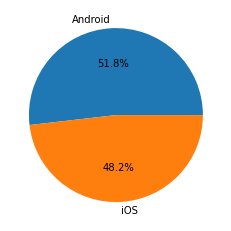

In [11]:
#Круговая диаграмма по ОС пользователей
plt.pie(df_os_pie.user_id, labels=df_os_pie.index, autopct="%1.1f%%")

### Информация по отменам

In [12]:
#Кол-во отменённых поездок
df['user_cancelled'].sum()

11269

In [13]:
print('Отмены составляют ', (df['user_cancelled'].sum()*100/df['order_made'].sum()).round(0), '% от общего числа заказов.')

Отмены составляют  15.0 % от общего числа заказов.


In [14]:
#DF по отменённым поездкам
df_cancelled = df[df['user_cancelled'] == 1]
df_cancelled.describe()

,user_id,hour,app_opened,price_seen,order_made,ride_completed,user_cancelled,age,city_center_order,distance
count,11269.000000,11269.000000,11269.0,11269.0,11269.0,11269.0,11269.0,11269.000000,11269.000000,11269.000000
mean,550824.891206,11.372438,1.0,1.0,1.0,0.0,1.0,43.477948,0.500222,5.098751
std,257984.931967,6.971733,0.0,0.0,0.0,0.0,0.0,15.020840,0.500022,3.918564
min,100118.000000,0.000000,1.0,1.0,1.0,0.0,1.0,18.000000,0.000000,0.025761
25%,328222.000000,5.000000,1.0,1.0,1.0,0.0,1.0,30.000000,0.000000,2.314856
50%,552128.000000,11.000000,1.0,1.0,1.0,0.0,1.0,44.000000,1.000000,4.062219
75%,773497.000000,17.000000,1.0,1.0,1.0,0.0,1.0,57.000000,1.000000,6.700610
max,999878.000000,23.000000,1.0,1.0,1.0,0.0,1.0,69.000000,1.000000,31.475713


In [15]:
#Количество уникальных пользователей
df_cancelled.user_id.nunique()

9043

In [16]:
#Сводная таблица: кол-во уникальных пользователей по os
df_os_cancel = pd.pivot_table(df_cancelled, index="os", values="user_id", aggfunc='nunique', margins=False)
df_os_cancel.sort_values(by='user_id', ascending=False)

,user_id
os,
Android,6345
iOS,3601


([<matplotlib.patches.Wedge at 0x7f801ab5abf0>,
 [Text(-0.4619214267977417, 0.9983128745364045, 'Android'),
  Text(0.46192133332894214, -0.9983129177846055, 'iOS')],
 [Text(-0.2519571418896772, 0.5445342952016751, '63.8%'),
  Text(0.25195709090669566, -0.544534318791603, '36.2%')])

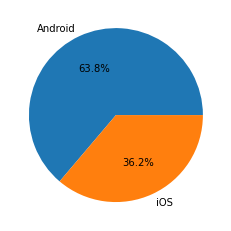

In [17]:
#Круговая диаграмма по ОС пользователей
plt.pie(df_os_cancel.user_id, labels=df_os_cancel.index, autopct="%1.1f%%")

Более половины всех отмен заказов приходится на пользователей с ОС Android (63,8%).

#### Пользователи андроид и среднее количество отмен

In [18]:
#фильтр для пользователей андроид
df_android = df[df['os'] == 'Android']
df_android

,date,user_id,hour,app_opened,price_seen,order_made,surge,ride_completed,user_cancelled,age,os,city_center_order,order_class,distance,rfm
1,2020-05-23,752172,5,1,1,1,no surge,1,0,37,Android,1,economy,2.908468,high
2,2020-05-20,486559,15,1,1,1,no surge,1,0,47,Android,0,comfort,7.224614,low
3,2020-05-19,304024,0,1,1,1,no surge,1,0,59,Android,1,economy,1.874349,low
4,2020-05-23,139420,0,1,1,1,no surge,1,0,19,Android,0,business,10.704778,medium
5,2020-05-21,139455,5,1,0,0,NaN,0,0,60,Android,1,comfort,NaN,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101489,2020-05-20,969159,22,1,0,0,NaN,0,0,67,Android,0,comfort,NaN,medium
101490,2020-05-20,780673,20,1,1,0,surge,0,0,67,Android,1,comfort,5.439498,medium
101491,2020-05-21,456333,10,1,1,1,no surge,1,0,34,Android,1,business,16.003392,high
101495,2020-05-24,288445,16,1,1,1,no surge,1,0,29,Android,0,comfort,1.725907,high


In [19]:
#Сводная таблица по пользователям-android и среднему количеству отмен.
#Поскольку в выбранной выше гипотезе идёт речь об отменах, 
#то для последующего теста на однородность берём среднее количество отмен по каждому пользователю
df_android_mean_cancel = pd.pivot_table(df_android, index='user_id', values='user_cancelled', aggfunc='mean')
df_android_mean_cancel

,user_cancelled
user_id,
100093,0.000000
100118,0.500000
100134,0.250000
100166,0.250000
100255,0.250000
...,...
999870,0.500000
999878,0.333333
999945,0.000000


### Расчёт показателей

In [20]:
# Стандартное отклонение
sd = np.std(df_android_mean_cancel)
sd

user_cancelled    0.244769
dtype: float64

In [21]:
# Минимальное значение выборки n
""" n = (Z^2*p*q)/∆^2
    n — объем выборки, который мы хотим вычислить. 
    Z — коэффициент, который берут из специальной таблицы в зависимости от доверительного уровня. 
    Обычно значения доверительного уровня равны 0.95 и 0.99. Значения Z при данных уровнях равно 1.96 и 1.98.
    p — это количество пользователей по истории, которое совершали нужно действие
    Если исторических данных нет, то используется значение равное 0.5 (50%).
    q = 1 - p — доля респондентов, у которых исследуемый признак отсутствует.
    ∆ — предельная ошибка выборки. 
    Считается, что для принятия бизнес-решений ошибка выборки должна быть не больше 4%. 
    Этому значению соответствует объем выборки в 500-600 респондентов.
"""
n = (1.96**2*0.5*0.5)/0.04**2
print(n)

600.2499999999999


In [22]:
# MDE
def estimate_effect_size(sd, n, alpha=0.05, power=0.8):
    """
    Расчет MDE для баланса 50/50
    :param sd: стандартное отклонение
    :param n: размер выбрки в одной группе
    :return: MDE
    """
    S = np.sqrt((sd**2 / n) + (sd**2 / n))
    M = norm.ppf(q=1-alpha/2) + norm.ppf(q=power)
    return M * S

In [23]:
sd = sd
estimate_effect_size(sd, n)

user_cancelled    0.039583
dtype: float64

### Разделение на группы

In [24]:
#Разбиваем юзеров на группы рандомно
df_android_mean_cancel['rand'] = 0.0

for i in range(len(df_android_mean_cancel)):
    t = random.random()
    df_android_mean_cancel['rand'].values[i] = t
    
df_android_mean_cancel['group'] = df_android_mean_cancel['rand'].apply(lambda x: '1' if x<0.5 else '2')
df_android_mean_cancel

,user_cancelled,rand,group
user_id,,,
100093,0.000000,0.991199,2
100118,0.500000,0.830229,2
100134,0.250000,0.381440,1
100166,0.250000,0.956689,2
100255,0.250000,0.717332,2
...,...,...,...
999870,0.500000,0.285076,1
999878,0.333333,0.395469,1
999945,0.000000,0.933488,2


In [25]:
#смотрим длину групп 1 и 2
len(df_android_mean_cancel[df_android_mean_cancel['group']=='1']), len(df_android_mean_cancel[df_android_mean_cancel['group']=='2'])

(10988, 11166)

In [26]:
#Приводим к одинаковой длине в 600 юзеров
group_1a = df_android_mean_cancel[df_android_mean_cancel['group']=='1'].sample(600)
group_2a = df_android_mean_cancel[df_android_mean_cancel['group']=='2'].sample(600)

### Проверка групп 1 и 2 на однородность (Критерий Манна-Уитни) 

Н0: группы 1 и 2 однородные

Н1: группы 1 и 2 имеют значимые различия

In [27]:
#Проверка на однородность U-test
stat, p = stats.mannwhitneyu(group_1a['user_cancelled'], group_2a['user_cancelled'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# интерпретация
alpha = 0.05
if p > alpha:
	print('Однородное распределение (не отклоняем Н0)')
else:
	print('Различное распределение (отклоняем Н0)')

Statistics=177496.500, p=0.604
Однородное распределение (не отклоняем Н0)
